### 1. Loss Ratio Analysis

The Loss Ratio is a key metric in insurance that measures the ratio of claims paid out to premiums earned. It indicates the profitability and risk of the portfolio. A higher loss ratio suggests more claims relative to premiums collected.

Here, we calculate the overall Loss Ratio for the portfolio as:

\[
\text{Loss Ratio} = \frac{\text{TotalClaims}}{\text{TotalPremium}}
\]

Then, we analyze how the Loss Ratio varies across different categories: Province, VehicleType, and Gender.

We visualize these breakdowns using bar plots to identify any patterns or areas of concern.


In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="whitegrid")
from scipy.stats import shapiro
from scipy.stats import f_oneway
from scipy.stats import mannwhitneyu

In [7]:
df = pd.read_csv('../data/cleaned_data.csv')
df['LossRatio'] = df.apply(lambda row: row['TotalClaims'] / row['TotalPremium'] if row['TotalPremium'] > 0 else 0, axis=1)


In [8]:
# Calculate overall Loss Ratio
overall_loss_ratio = df['TotalClaims'].sum() / df['TotalPremium'].sum()
print(f"Overall Loss Ratio for the portfolio: {overall_loss_ratio:.4f}")


Overall Loss Ratio for the portfolio: 1.0483


In [9]:
# Group by Province, calculate mean Loss Ratio per Province
loss_ratio_province = df.groupby('Province')['LossRatio'].mean().sort_values(ascending=False)

# Group by VehicleType, mean Loss Ratio
loss_ratio_vehicle = df.groupby('VehicleType')['LossRatio'].mean().sort_values(ascending=False)

# Group by Gender, mean Loss Ratio
loss_ratio_gender = df.groupby('Gender')['LossRatio'].mean().sort_values(ascending=False)


Next, we visualize the average Loss Ratio across Province, VehicleType, and Gender using bar plots.


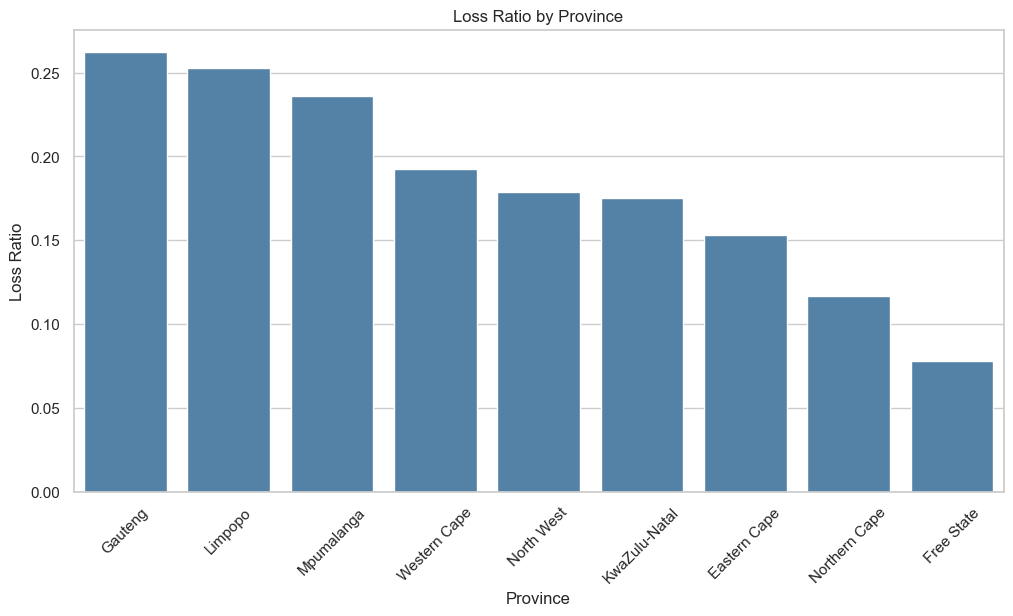

In [11]:
plt.figure(figsize=(12,6))
sns.barplot(x=loss_ratio_province.index, y=loss_ratio_province.values, color='steelblue')
plt.xticks(rotation=45)
plt.xlabel('Province')
plt.ylabel('Loss Ratio')
plt.title('Loss Ratio by Province')
plt.show()

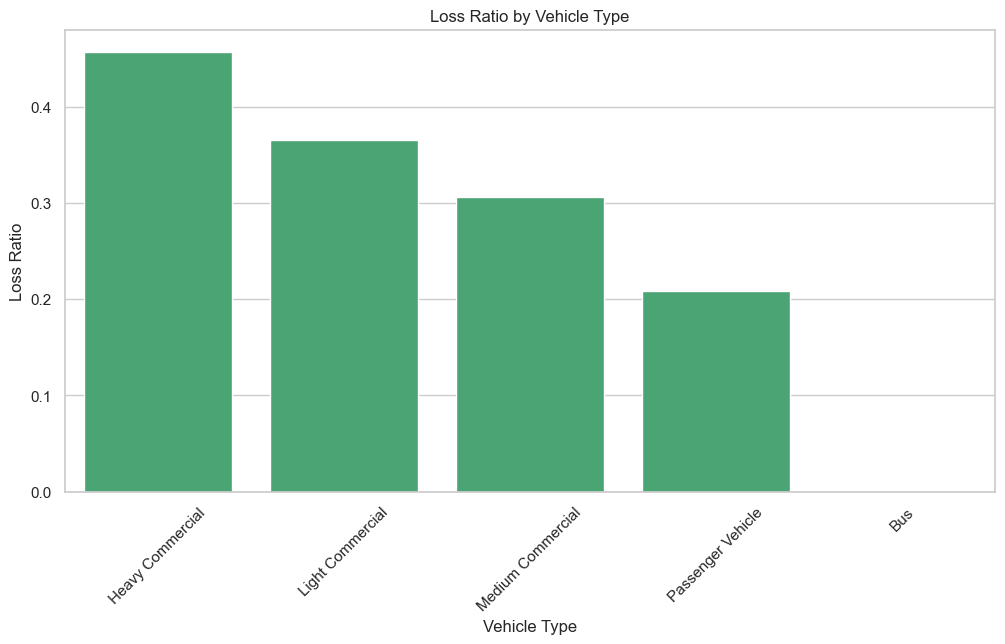

In [12]:
plt.figure(figsize=(12,6))
sns.barplot(x=loss_ratio_vehicle.index, y=loss_ratio_vehicle.values, color='mediumseagreen')
plt.xticks(rotation=45)
plt.xlabel('Vehicle Type')
plt.ylabel('Loss Ratio')
plt.title('Loss Ratio by Vehicle Type')
plt.show()


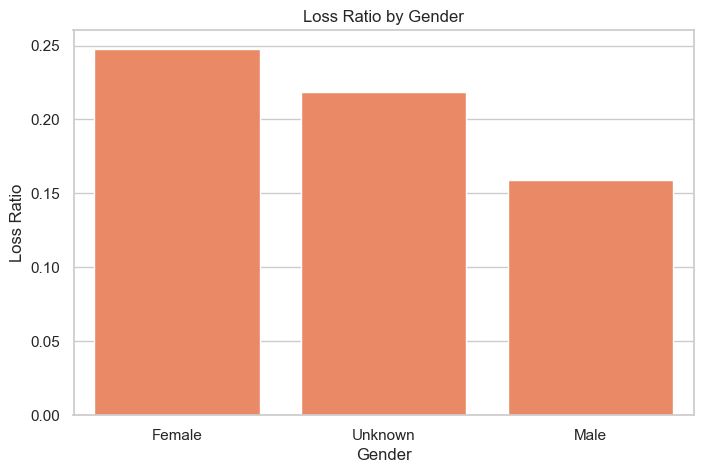

In [13]:
plt.figure(figsize=(8,5))
sns.barplot(x=loss_ratio_gender.index, y=loss_ratio_gender.values, color='coral')
plt.xlabel('Gender')
plt.ylabel('Loss Ratio')
plt.title('Loss Ratio by Gender')
plt.show()


 2. Statistical Thinking
- In this section, we apply statistical methods to validate patterns observed during EDA. We focus on:
- Assessing distribution shapes for key numeric variables.
- Normality testing to verify statistical assumptions.
- Hypothesis testing to examine whether differences in Loss Ratio across categorical groups (e.g., Gender, Province, VehicleType) are statistically significant.

In [22]:
# LossRatio by Province - use Kruskal-Wallis test for non-parametric group comparison
province_groups = df.groupby('Province')['LossRatio'].apply(list)
province_lists = [group for group in province_groups if len(group) > 30]  # Only include well-represented provinces

stat, p = kruskal(*province_lists)
print(f'Kruskal-Wallis test for LossRatio across Provinces: stat={stat:.3f}, p={p:.3f}')
if p < 0.05:
    print("Statistically significant differences in LossRatio between provinces (non-parametric).")
else:
    print(" No significant differences in LossRatio between provinces.")


Kruskal-Wallis test for LossRatio across Provinces: stat=98.332, p=0.000
Statistically significant differences in LossRatio between provinces (non-parametric).


In [19]:
# Group by gender
male_loss_ratio = df[df['Gender'] == 'Male']['LossRatio']
female_loss_ratio = df[df['Gender'] == 'Female']['LossRatio']

# Perform Mann-Whitney U test (non-parametric)
stat, p = mannwhitneyu(male_loss_ratio, female_loss_ratio, alternative='two-sided')
print(f'Mann-Whitney U test between Male and Female LossRatio: stat={stat:.3f}, p={p:.3f}')
if p < 0.05:
    print("Statistically significant difference in LossRatio between genders.")
else:
    print("No significant difference in LossRatio between genders.")


Mann-Whitney U test between Male and Female LossRatio: stat=143446663.500, p=0.896
No significant difference in LossRatio between genders.


In [20]:
# Filter provinces with enough samples
province_groups = df.groupby('Province')['LossRatio'].apply(list)
province_lists = [group for group in province_groups if len(group) > 30]  # Ignore provinces with very few samples

# Run ANOVA
stat, p = f_oneway(*province_lists)
print(f'ANOVA test for LossRatio across Provinces: stat={stat:.3f}, p={p:.3f}')
if p < 0.05:
    print("Statistically significant differences in LossRatio between provinces.")
else:
    print("No significant differences in LossRatio between provinces.")


ANOVA test for LossRatio across Provinces: stat=4.255, p=0.000
Statistically significant differences in LossRatio between provinces.


### Correlation Between Monthly Changes in TotalPremium and TotalClaims by ZipCode

To assess how closely premium collections relate to claim payouts at a regional level, we analyzed the correlation between monthly percentage changes in `TotalPremium` and `TotalClaims`, grouped by `ZipCode`. This helps identify regions with strong or weak claim-premium synchronization, which may reflect risk stability, fraud, or underpricing.


In [25]:
print(df.columns.tolist())


['UnderwrittenCoverID', 'PolicyID', 'TransactionMonth', 'IsVATRegistered', 'Citizenship', 'LegalType', 'Title', 'Bank', 'AccountType', 'MaritalStatus', 'Gender', 'Province', 'PostalCode', 'MainCrestaZone', 'SubCrestaZone', 'mmcode', 'VehicleType', 'RegistrationYear', 'make', 'Model', 'Cylinders', 'cubiccapacity', 'kilowatts', 'bodytype', 'NumberOfDoors', 'VehicleIntroDate', 'AlarmImmobiliser', 'TrackingDevice', 'CapitalOutstanding', 'NewVehicle', 'SumInsured', 'CalculatedPremiumPerTerm', 'CoverCategory', 'CoverType', 'CoverGroup', 'Section', 'Product', 'TotalPremium', 'TotalClaims', 'LossRatio']


In [28]:
# Ensure date is in Period format for monthly grouping
df['TransactionMonth'] = pd.to_datetime(df['TransactionMonth'])
df['TransactionMonth'] = df['TransactionMonth'].dt.to_period('M')

# Group by TransactionMonth and PostalCode
monthly_grouped = df.groupby(['TransactionMonth', 'PostalCode'])[['TotalPremium', 'TotalClaims']].sum().reset_index()
monthly_grouped.head()


,TransactionMonth,PostalCode,TotalPremium,TotalClaims
0,2013-10,7405,151.867402,0.000000
1,2013-10,7766,172.206933,0.000000
2,2013-10,7945,46.989177,0.000000
3,2013-11,1,1432.740561,50585.078947
4,2013-11,84,120.874211,0.000000


In [30]:
# Pivot for wide format
premium_pivot = monthly_grouped.pivot(index='TransactionMonth', columns='PostalCode', values='TotalPremium')
claims_pivot = monthly_grouped.pivot(index='TransactionMonth', columns='PostalCode', values='TotalClaims')

# Compute percentage change
premium_pct_change = premium_pivot.pct_change(fill_method=None)
claims_pct_change = claims_pivot.pct_change(fill_method=None)



In [36]:
corr_df = (
    pd.DataFrame({
        z: premium_pct_change[z].corr(claims_pct_change[z]) 
        if (premium_pct_change[z].notna() & claims_pct_change[z].notna()).sum() >= 3 else np.nan
        for z in common_zipcodes
    }, index=['Correlation'])
    .T
    .dropna()
    .sort_values('Correlation', ascending=False)
)


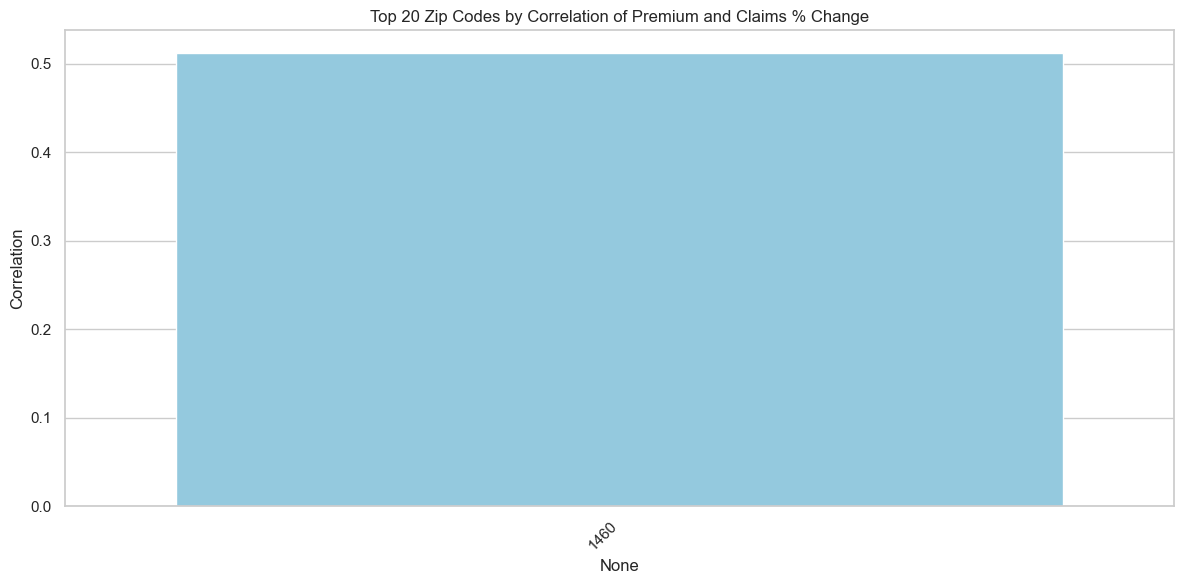

In [40]:
plt.figure(figsize=(12,6))
ax = sns.barplot(data=corr_df.head(20), x=corr_df.head(20).index, y='Correlation', color='skyblue')
ax.set_xticks(range(len(corr_df.head(20))))  # explicitly set positions
ax.set_xticklabels(corr_df.head(20).index, rotation=45, ha='right')
plt.title('Top 20 Zip Codes by Correlation of Premium and Claims % Change')
plt.tight_layout()
plt.show()

### 4. Data Comparison / Trends Over Geography

This section explores how insurance-related variables such as CoverType, TotalPremium, and VehicleMake vary across different Provinces or PostalCodes. These comparisons help identify geographical patterns in customer preferences, product types, and potential areas of risk or opportunity.


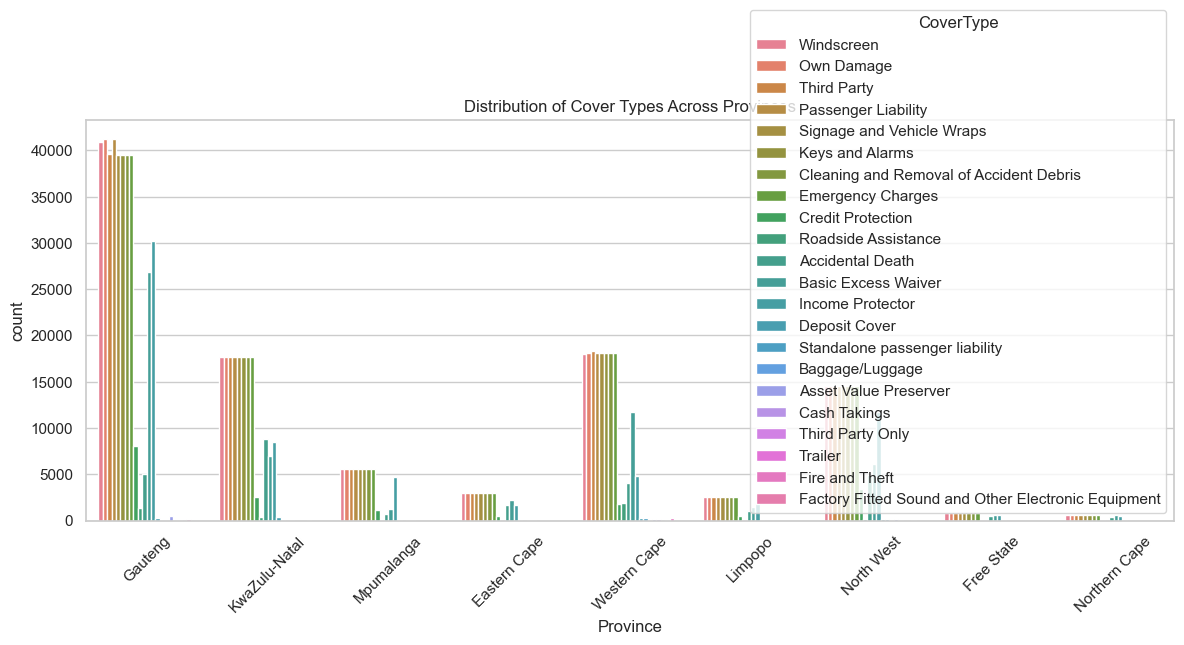

In [41]:
plt.figure(figsize=(12,6))
sns.countplot(data=df, x='Province', hue='CoverType')
plt.title('Distribution of Cover Types Across Provinces')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


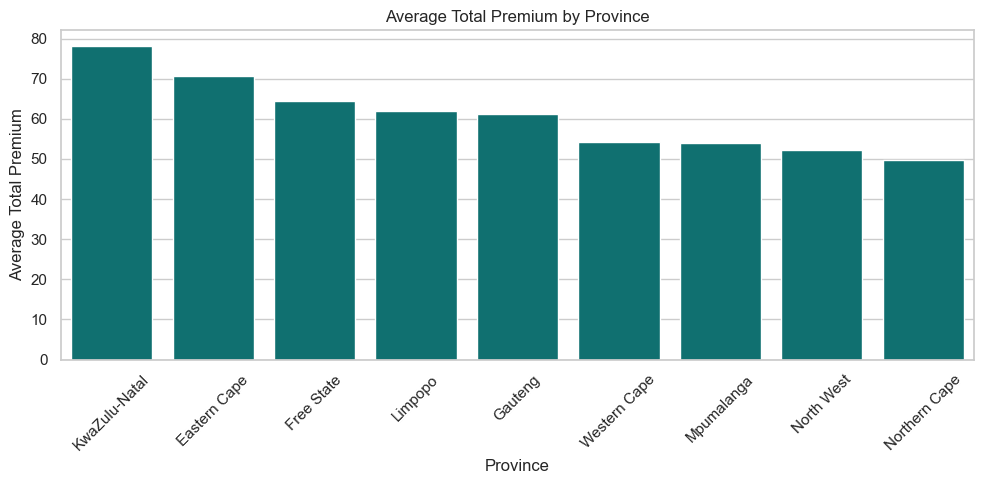

In [42]:
avg_premium_province = df.groupby('Province')['TotalPremium'].mean().sort_values(ascending=False)

plt.figure(figsize=(10,5))
sns.barplot(x=avg_premium_province.index, y=avg_premium_province.values, color='teal')
plt.title('Average Total Premium by Province')
plt.ylabel('Average Total Premium')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [43]:
if 'VehicleMake' in df.columns:
    top_makes = df['VehicleMake'].value_counts().nlargest(10).index
    df_top_makes = df[df['VehicleMake'].isin(top_makes)]
    
    plt.figure(figsize=(12,6))
    sns.countplot(data=df_top_makes, x='VehicleMake', hue='Province')
    plt.title('Top 10 Vehicle Makes by Province')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


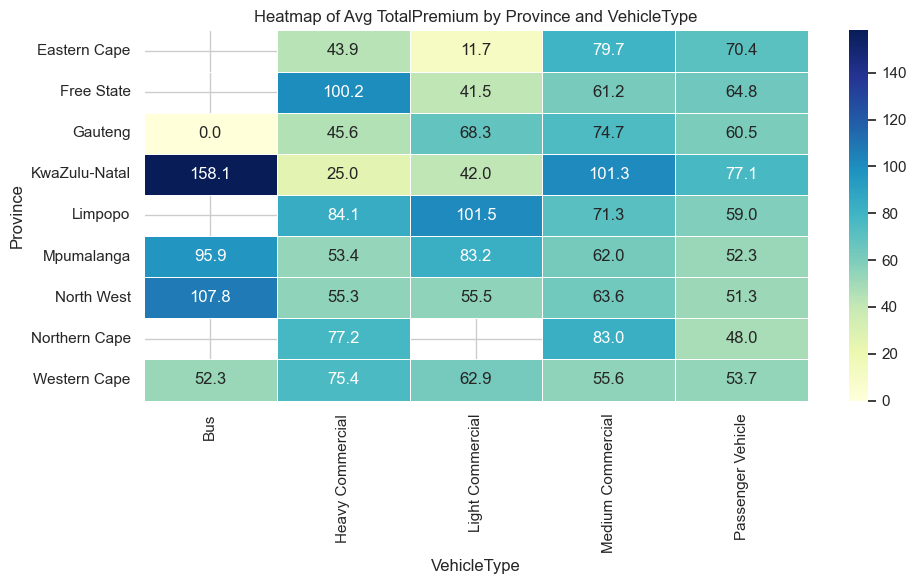

In [44]:
pivot = df.pivot_table(values='TotalPremium', index='Province', columns='VehicleType', aggfunc='mean')

plt.figure(figsize=(10,6))
sns.heatmap(pivot, annot=True, fmt=".1f", cmap="YlGnBu", linewidths=0.5)
plt.title('Heatmap of Avg TotalPremium by Province and VehicleType')
plt.tight_layout()
plt.show()


### 5. Additional Outlier Analysis

This section identifies extreme outliers in important financial variables such as `TotalClaims` and `CustomValueEstimate`. Outliers can significantly skew analysis, so detecting and flagging them enables robust sensitivity checks. We use the Interquartile Range (IQR) method to define outliers.


In [45]:
def detect_outliers_iqr(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return (series < lower_bound) | (series > upper_bound)

# Detect outliers
df['Outlier_TotalClaims'] = detect_outliers_iqr(df['TotalClaims'])

if 'CustomValueEstimate' in df.columns:
    df['Outlier_CustomValueEstimate'] = detect_outliers_iqr(df['CustomValueEstimate'])


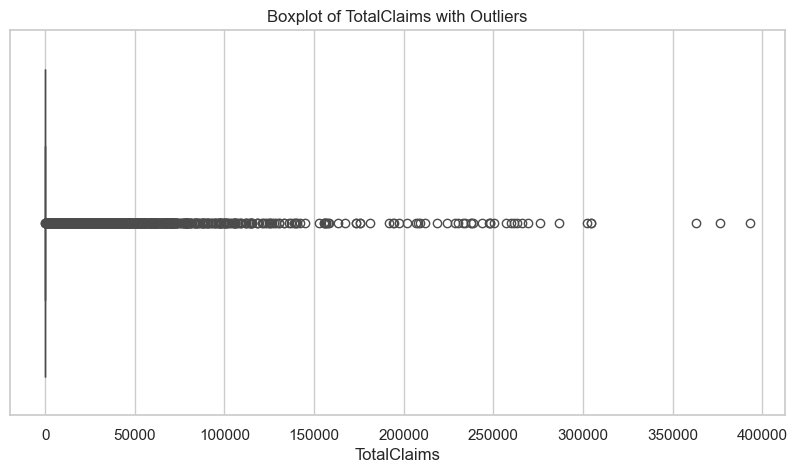

In [46]:
plt.figure(figsize=(10, 5))
sns.boxplot(x=df['TotalClaims'])
plt.title('Boxplot of TotalClaims with Outliers')
plt.show()


In [47]:
if 'CustomValueEstimate' in df.columns:
    plt.figure(figsize=(10, 5))
    sns.boxplot(x=df['CustomValueEstimate'])
    plt.title('Boxplot of CustomValueEstimate with Outliers')
    plt.show()


In [48]:
print(f"TotalClaims outliers: {df['Outlier_TotalClaims'].sum()}")

if 'CustomValueEstimate' in df.columns:
    print(f"CustomValueEstimate outliers: {df['Outlier_CustomValueEstimate'].sum()}")


TotalClaims outliers: 2775


In [49]:
# Filter without outliers
df_no_outliers = df[~df['Outlier_TotalClaims']]

# Compare mean TotalClaims
print("Mean TotalClaims (All):", df['TotalClaims'].mean())
print("Mean TotalClaims (No Outliers):", df_no_outliers['TotalClaims'].mean())


Mean TotalClaims (All): 64.40022860838042
Mean TotalClaims (No Outliers): 0.0


### 6. Creative & Beautiful Visualizations

This section showcases three carefully selected, visually appealing plots that summarize the most impactful insights from the EDA. Each plot has been styled for clarity, with custom themes, annotations, and meaningful titles.


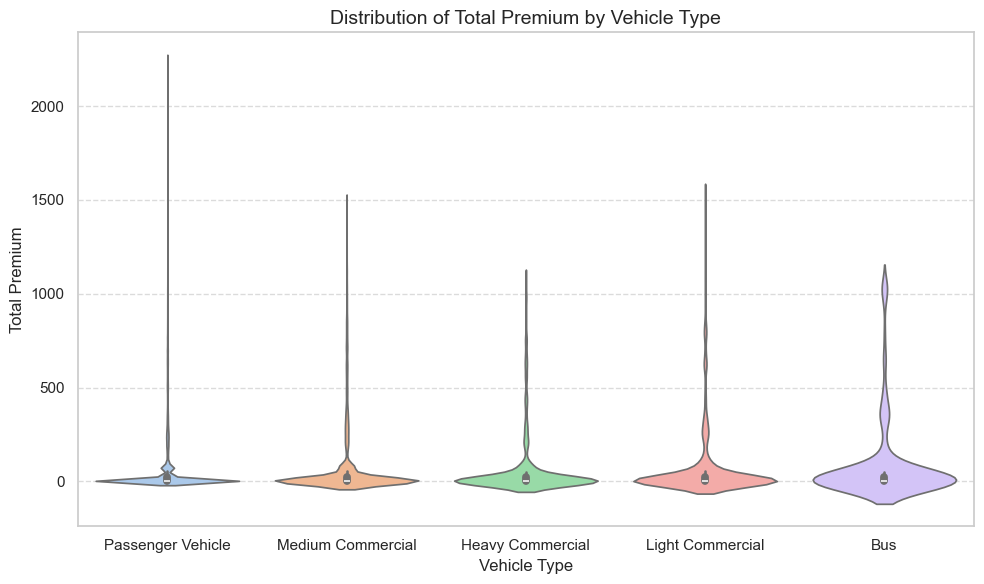

In [51]:
plt.figure(figsize=(10, 6))
sns.violinplot(data=df, x='VehicleType', y='TotalPremium', hue='VehicleType', palette='pastel', legend=False)
plt.title('Distribution of Total Premium by Vehicle Type', fontsize=14)
plt.xlabel('Vehicle Type')
plt.ylabel('Total Premium')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


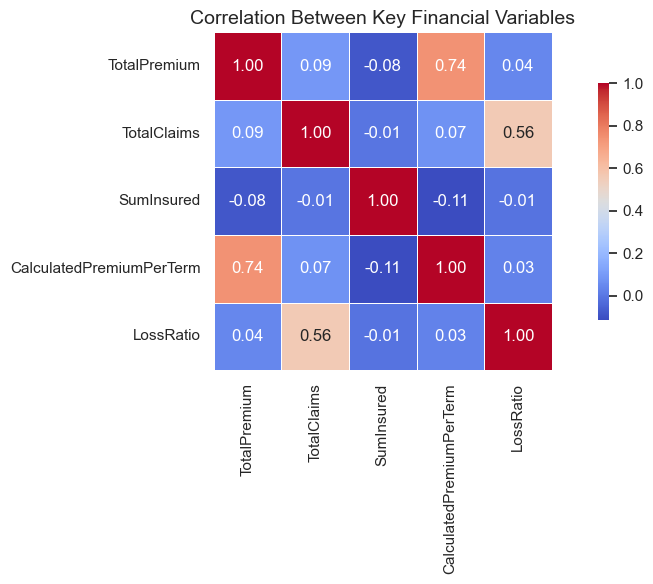

In [52]:
plt.figure(figsize=(10, 6))
numeric_cols = ['TotalPremium', 'TotalClaims', 'SumInsured', 'CalculatedPremiumPerTerm', 'LossRatio']
corr = df[numeric_cols].corr()

sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, square=True, cbar_kws={'shrink': 0.7})
plt.title('Correlation Between Key Financial Variables', fontsize=14)
plt.tight_layout()
plt.show()


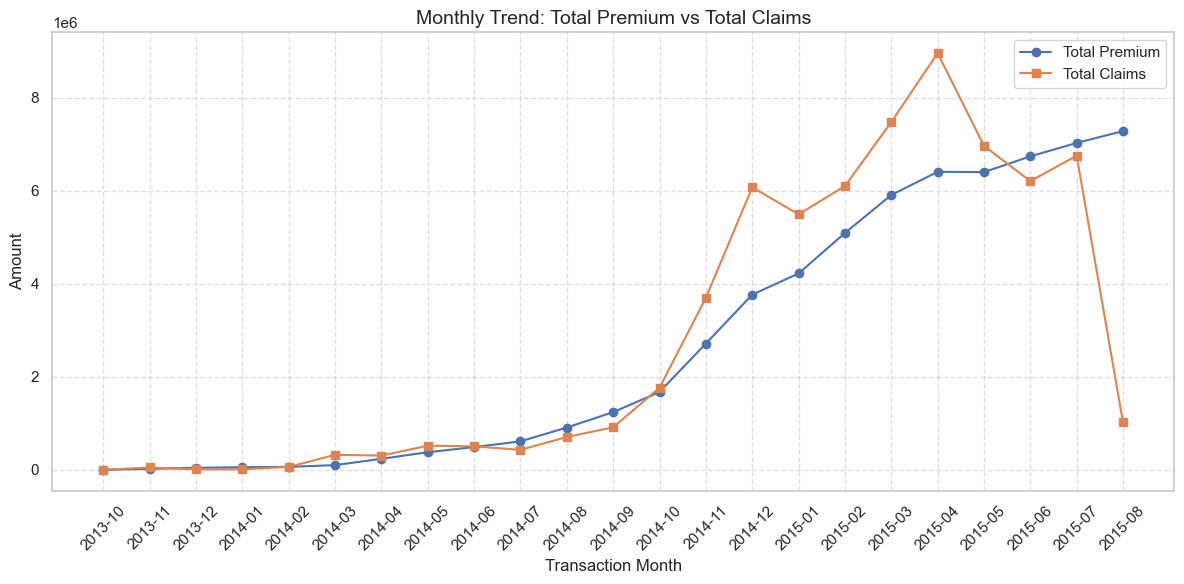

In [55]:
# Ensure 'TransactionMonth' is converted to string (or datetime)
monthly['TransactionMonth'] = monthly['TransactionMonth'].astype(str)

# Plot
plt.figure(figsize=(12, 6))
plt.plot(monthly['TransactionMonth'], monthly['TotalPremium'], label='Total Premium', marker='o')
plt.plot(monthly['TransactionMonth'], monthly['TotalClaims'], label='Total Claims', marker='s')

plt.title('Monthly Trend: Total Premium vs Total Claims', fontsize=14)
plt.xlabel('Transaction Month')
plt.ylabel('Amount')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()
